In [36]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone --single-branch --branch main https://github.com/GrigoryBartosh/dul_2021
!unzip -qq dul_2021/Homework/hw1/data/hw1_data.zip -d dul_2021/Homework/hw1/data/
!mv -v dul_2021/Homework/hw1/data/hw1_data/* dul_2021/Homework/hw1/data/
!rmdir dul_2021/Homework/hw1/data/hw1_data/
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 123 (delta 48), reused 110 (delta 38), pack-reused 0
Receiving objects: 100% (123/123), 26.18 MiB | 32.69 MiB/s, done.
Resolving deltas: 100% (48/48), done.
renamed 'dul_2021/Homework/hw1/data/hw1_data/geoffrey-hinton.jpg' -> 'dul_2021/Homework/hw1/data/geoffrey-hinton.jpg'
renamed 'dul_2021/Homework/hw1/data/hw1_data/mnist_colored.pkl' -> 'dul_2021/Homework/hw1/data/mnist_colored.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/mnist.pkl' -> 'dul_2021/Homework/hw1/data/mnist.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/shapes_colored.pkl' -> 'dul_2021/Homework/hw1/data/shapes_colored.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/shapes.pkl' -> 'dul_2021/Homework/hw1/data/shapes.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/smiley.jpg' -> 'dul_2021/Homework/hw1/data/smiley.jpg'
Processing ./dul_20

In [37]:
from dul_2021.utils.hw2_utils import *

In [38]:
import os
import numpy as np
import copy
from itertools import chain

import torch
import torch.nn as nn
import torch.optim as opt
from torch.autograd import Variable
import torch.nn.functional as F
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal
from tqdm import tqdm

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Question 1 PixelCNNs

## Part (a) PixelCNN on Colored Shapes and MNIST: Independent Color Channels

For the next two parts, we'll work with color images (shapes and MNIST). Run the cell below to visualize the dataset.

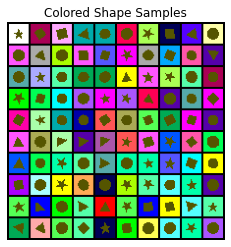

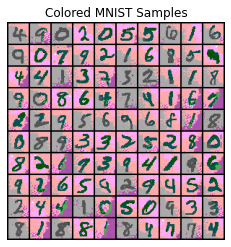

In [40]:
visualize_q1a_data(1)
visualize_q1a_data(2)
# you can get access to the data with q1ab_get_data

Now, implement a PixelCNN to support RGB color channels (or augment your existing implementation). **First, implement a PixelCNN that assumes color channels as independent.** More formally, we model the following parameterized distribution:

$$p_\theta(x) = \prod_{i=1}^{HW}\prod_{c=1}^C p_\theta(x_i^c | x_{<i})$$

Here are some tips that you may find useful for designing and training these models:
* You will need a 4-way softmax for every prediction, as opposed to a 256-way softmax in the PixelCNN paper, since the dataset is quantized to two bits per color channel
* You can set number of filters for each convolutions to 120. You can use the ReLU nonlinearity throughout.
* Use a stack of 8 residual block architecture from [Figure 5](https://arxiv.org/abs/1601.06759) but with 7 x 7 masked convolutions in the middle instead of 3 x 3 masked convolutions
* Consider using [layer normalization](https://arxiv.org/abs/1607.06450) to improve performance. However, be careful to maintain the autoregressive property.
* With a learning rate of $10^{-3}$ and a batch size of 128, it should take a few minutes to run on the shapes dataset, and about 50-60 minutes on MNIST.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [41]:
class MaskLayer(nn.Conv2d):
  def __init__(self, mask_type, *args, **kwargs):
    super(MaskLayer, self).__init__(*args, **kwargs)

    self.mask=self.weight.data.clone().to(device)
    
    _, depth, height, width = self.weight.size()
    self.mask.fill_(1)
    if mask_type =='A':
      self.mask[:,:,height//2,width//2:] = 0
      self.mask[:,:,height//2+1:,:] = 0
    else:
      self.mask[:,:,height//2,width//2+1:] = 0
      self.mask[:,:,height//2+1:,:] = 0
  
  def forward(self, x):
    self.weight.data *= self.mask
    return super(MaskLayer, self).forward(x)


class ColorMaskLayer(nn.Conv2d):
  def __init__(self, mask_type, *args, **kwargs):
    super(ColorMaskLayer, self).__init__(*args, **kwargs)
    self.mask=self.weight.data.clone().to(device)
    
    _, depth, height, width = self.weight.size()
    self.mask.fill_(1)


    if mask_type =='A':
      self.mask[:,:,height//2,width//2:] = 0
      self.mask[:,:,height//2+1:,:] = 0
    else:
      self.mask[:,:,height//2,width//2+1:] = 0
      self.mask[:,:,height//2+1:,:] = 0

  def _choose_group(self, mask_group):
    self.mask[:,:,height//2 + 1,width//2 + 1] = 0
    self.mask[:,mask_group,height//2 + 1,width//2 + 1] = 1
  
  def forward(self, x, mask_group):
    self._choose_group(mask_group)
    self.weight.data *= self.mask
    return super(MaskLayer, self).forward(x)

  def get_mask(self):
    return self.mask

class ResnetBlock(nn.Module):
  def __init__(self, in_channels, drop_last=False, **kwargs):
    super().__init__()
    self.relu = nn.ReLU(True)
    self.conv1 = ColorMaskLayer('B', in_channels, in_channels // 2, 1, **kwargs)
    self.conv2 = ColorMaskLayer('B', in_channels // 2, in_channels // 2, 7, padding=3, **kwargs)
    self.conv3 = ColorMaskLayer('B', in_channels // 2, in_channels, 1, **kwargs)

  def forward(self, x, mask_group):
    x_skip = x
    x = self.relu(x)
    x = self.conv1(x, mask_group)
    x = self.relu(x)
    x = self.conv2(x, mask_group)
    x = self.relu(x)
    x = self.conv3(x, mask_group)
    return x + x_skip

class LayerNorm(nn.LayerNorm):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)

  def forward(self, x):
    x = x.permute(0, 2, 3, 1).contiguous()
    x = super().forward(x)
    return x.permute(0, 3, 1, 2).contiguous()


class CommonBlock(nn.Module):
  def __init__(self, channels, drop_last=False, **kwargs):
    super().__init__()
    self.norm = LayerNorm(channels)
    self.relu = nn.ReLU(True)
    self.res = ResnetBlock(channels, bias=False)

  def forward(self, x, mask_group):
    x = self.norm(x)
    x = self.relu(x)
    x = self.res(x, mask_group)
    return x + x_skip


class PixelCNN(nn.Module):
  def __init__(self, no_layers=8, kernel = 7, channels=120, device=None):
    super(PixelCNN, self).__init__()
    
    self.device = device
    self.n = 2
    self.nll_loss = nn.NLLLoss()
    self.channels = channels
    self.kernel = kernel
  

    self.first = nn.Sequential(*[MaskLayer('A', 3, self.channels, self.kernel, 1, self.kernel//2, bias=False), 
                                 nn.BatchNorm2d(self.channels),
                                 nn.ReLU(True)])
    
    layers = []
    for i in range(8):
      layers.append(CommonBlock(self.channels))
    
    self.second = nn.Sequential(*layers)
    self.out = nn.Conv2d(self.channels, 4, 1)

    
  def forward(self, x):
    x = self.first(x)

    r_out = self.second(x, 0)
    g_out = self.second(x, 1)
    b_out = self.second(x, 2)

    x = torch.cat((r_out[:, 0, :, :], r_out[:, 1, :, :], r_out[:, 2, :, :]), dim=1)

    x = self.out(x)
    return r_out + g_out + b_out
    
  def loss(self, x):
    r, g, b = self(x).split(4, dim)

    r_log_soft = torch.softmax(r, dim=1).log()
    g_log_soft = torch.softmax(g, dim=1).log()
    b_log_soft = torch.softmax(b, dim=1).log()

    r_tar, g_tar, b_tar = x.long().split(1, 1)

    output = self.nll_loss(r_log_soft, r_tar.reshape(-1, 20, 20))
    output += self.nll_loss(g_log_soft, g_tar.reshape(-1, 20, 20))
    output += self.nll_loss(b_log_soft, b_tar.reshape(-1, 20, 20))

    return output

  def predict(self, testloader):
    loss = 0
    tl = 0
    with torch.no_grad():
      for batch in testloader:
        batch = batch.to(device)
        loss += self.loss(batch.to(device).float()) * batch.shape[0]
        tl += batch.shape[0]
        return loss / tl
    
  def fit(self, train_data, test_data, epochs=10, lr=1e-3, batch_size=128):
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size, 
                                               shuffle=True)
    
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_size)
    train_loss = []
    test_loss = []
    test_loss.append(self.predict(test_loader))
    optim = opt.Adam(self.parameters(), lr=lr)
    
    for epoch in tqdm(range(epochs)):
      for batch in train_loader:
        batch = batch.to(device)
        batch = batch.float()
        loss = self.loss(batch)
        optim.zero_grad()
        loss.backward()
        optim.step()
      
        train_loss.append(self.predict(train_loader))
      test_loss.append(self.predict(test_loader))
    
    return train_loss, test_loss
    
   

In [42]:
device

device(type='cuda')

In [43]:
def q1_a(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
  """
  
  
  train_data = train_data.transpose(0, 3, 1, 2)
  test_data = test_data.transpose(0, 3, 1, 2)

  h, w = 20, 20
  model = PixelCNN().to(device)

  tr_loss, test_loss = model.fit(train_data, test_data, epochs=10, lr=1e-3, batch_size=128)
  # samples = model.sample(100)
  samples = np.zeros((100, 20, 20, 4))
  return tr_loss, test_loss, samples

### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



In [44]:
q1ab_save_results(1, 'a', q1_a)

TypeError: ignored

In [ ]:
q1ab_save_results(1, 'a', q1_a)

In [ ]:
q1ab_save_results(1, 'a', q1_a)

In [ ]:
q1ab_save_results(2, 'a', q1_b)

## Part (b) PixelCNN on Colored Shapes and MNIST: Autoregressive Color Channels

Now, implement a PixelCNN that models **dependent** color channels. Formally, we model the parameterized distribution

$$p_\theta(x) = \prod_{i=1}^{HW}\prod_{c=1}^C p_\theta(x_i^c | x_i^{<c}, x_{<i})$$

To do so, change your masking scheme for the center pixel. Split the filters into 3 groups, only allowing each group to see the groups before (or including the current group, for type B masks) to maintain the autoregressive property.

Training times and hyperparameter settings should be the same as part (b).

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q1_b(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
  """
  
  """ YOUR CODE HERE """

### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results



In [ ]:
q1ab_save_results(1, 'b', q1_b)

In [ ]:
q1ab_save_results(2, 'b', q1_b)

## Part (c) Conditional PixelCNNs

In this part, implement and train a **class-conditional** PixelCNN on binary MNIST. Condition on a class label by adding a conditional bias in each convolutional layer. More precisely, in the $\ell$th convolutional layer, compute: 
$$W_\ell * x + b_\ell + V_\ell y$$
where $W_\ell * x + b_\ell$ is a masked convolution (as in previous parts), $V$ is a 2D weight matrix, and $y$ is a one-hot encoding of the class label (where the conditional bias is broadcasted spacially and added channel-wise).

You can use a PixelCNN architecture similar to part (a). Training on the shapes dataset should be quick, and MNIST should take around 10-15 minutes


**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
# you can get access to data with q1c_get_data(dset_type)

In [ ]:
def q1_c(train_data, train_labels, test_data, test_labels, image_shape, n_classes, dset_id):
  """
  train_data: A (n_train, H, W, 1) numpy array of binary images with values in {0, 1}
  train_labels: A (n_train,) numpy array of class labels
  test_data: A (n_test, H, W, 1) numpy array of binary images with values in {0, 1}
  test_labels: A (n_test,) numpy array of class labels
  image_shape: (H, W), height and width
  n_classes: number of classes (4 or 10)
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, C, 1) of samples with values in {0, 1}
    where an even number of images of each class are sampled with 100 total
  """
  
  """ YOUR CODE HERE """

### Results

Once you've implemented `q1_c`, execute the cells below to visualize and save your results



In [ ]:
q1c_save_results(1, q1_c)

In [ ]:
q1c_save_results(2, q1_c)

# Bonus 1: Bonus Questions (Optional)

## Part (a) Gated PixelCNN
Implement a [Gated PixelCNN](https://arxiv.org/abs/1606.05328) to fix the blind-spot issue, and report training curves, final test loss, and samples.

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
#b1ab_get_data()

In [ ]:
def b1_a(train_data, test_data, image_shape):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, C) of generated samples with values in {0, 1, 2, 3}
  """
  """ YOUR CODE HERE """

### Results

Once you've implemented `b1_a`, execute the cells below to visualize and save your results



In [ ]:
b1a_save_results(b1_a)

## Part (b) Grayscale PixelcNN
Train a [Grayscale PixelCNN](https://arxiv.org/abs/1612.08185) on Colored MNIST. You do not need to use their architecture - stacking standard masked convolutions or residual blocks is fine. First, generate a binary image, and then the 2-bit color image.

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def b1_b(train_data, test_data, image_shape):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (50, H, W, 1) of generated binary images in {0, 1}
  - a numpy array of size (50, H, W, C) of conditonally generated color images in {0, 1, 2, 3}
  """
  # You will need to generate the binary image dataset from train_data and test_data
  
  """ YOUR CODE HERE """

### Results

Once you've implemented `b1_b`, execute the cells below to visualize and save your results



In [ ]:
q1b_save_results(q1_b)

## Part (c) Parallel Multiscale PixelCNN
One large disadvantage of autoregressive models is their slow sampling speed, since they require one network evaluation per feature. However, there are existing methods which introduce different independence assumptions to allow for parallelism when sampling. Implement a [Parallel PixelCNN](https://arxiv.org/abs/1703.03664) on 56 x 56 MNIST images, with a base size of 7 x 7 and upscaling by a factor of 2. Sampling should be very quick (< 1s). Architectures may vary, but using small PixelCNN implementation similar to previous parts and small ResNets should suffice

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
#b1c_get_data()

In [ ]:
def b1_c(train_data, test_data):
  """
  train_data: A (60000, 56, 56, 1) numpy array of grayscale images with values in {0, 1}
  test_data: A (10000, 56, 56, 1) numpy array of grayscale images with values in {0, 1}
  image_shape: (H, W), height and width

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, 56, 56, 1) of generated samples with values in {0, 1}
  """
 
  """ YOUR CODE HERE """

### Results

Once you've implemented `b1_c`, execute the cells below to visualize and save your results



In [ ]:
b1c_save_results(b1_c)